In [1]:
import pandas as pd
pd.set_option('max_colwidth', -1)
pd.set_option('display.max_rows', 500)

from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, DataFrame as D
from pyspark.sql.window import Window
spark = SparkSession.builder.appName('abc').getOrCreate()

### EXPLORING WINDOW TIMES

In [2]:
df_frequencies = spark.read.option("header","true").csv("frequencies.csv")

In [3]:
df_frequencies.limit(2).toPandas()

,year,month,day,busstop_number,name,latitude,longitude,time_span5min,next_time_span5min,time_span10min,...,set_vehicles20min,set_lines20min,count_lines25min,count_vehicles25min,set_vehicles25min,set_lines25min,count_lines30min,count_vehicles30min,set_vehicles30min,set_lines30min
0,2019,5,1,660104,"Rua Amazonas, 197 - Jd. Cecilia - Campo Magro - PR",-25.38146,-49.36393,2019-05-01 06:05:00,2019-05-01 06:10:00,2019-05-01 06:00:00,...,['MN400'],['928'],1,1,['MN400'],['928'],1,1,['MN400'],['928']
1,2019,5,1,660104,"Rua Amazonas, 197 - Jd. Cecilia - Campo Magro - PR",-25.38146,-49.36393,2019-05-01 07:05:00,2019-05-01 07:10:00,2019-05-01 07:00:00,...,['MN400'],['928'],1,1,['MN400'],['928'],1,1,['MN400'],['928']


In [4]:
df_frequencies.filter("day == 1").limit(2).toPandas()

,year,month,day,busstop_number,name,latitude,longitude,time_span5min,next_time_span5min,time_span10min,...,set_vehicles20min,set_lines20min,count_lines25min,count_vehicles25min,set_vehicles25min,set_lines25min,count_lines30min,count_vehicles30min,set_vehicles30min,set_lines30min
0,2019,5,1,660104,"Rua Amazonas, 197 - Jd. Cecilia - Campo Magro - PR",-25.38146,-49.36393,2019-05-01 06:05:00,2019-05-01 06:10:00,2019-05-01 06:00:00,...,['MN400'],['928'],1,1,['MN400'],['928'],1,1,['MN400'],['928']
1,2019,5,1,660104,"Rua Amazonas, 197 - Jd. Cecilia - Campo Magro - PR",-25.38146,-49.36393,2019-05-01 07:05:00,2019-05-01 07:10:00,2019-05-01 07:00:00,...,['MN400'],['928'],1,1,['MN400'],['928'],1,1,['MN400'],['928']


##### TAKING TOP 10 LINES WITH HIGHEST NUMBER OF LINES

In [8]:
df_mean_lines = (df_frequencies.groupBy(["busstop_number","name","latitude","longitude"]).agg(F.mean('count_lines10min').alias("nr_medio_linhas"), F.stddev('count_lines10min').alias("stddev_linhas") )
.orderBy(F.desc('nr_medio_linhas')).limit(10))

In [6]:
df_mean_lines.toPandas()

,busstop_number,name,latitude,longitude,nr_medio_linhas,stddev_linhas
0,150332,"Rua Leon Nicolas, 2081 - Cap?o Raso",-25.515159644727,-49.294443608469,3.221893,1.552597
1,150331,"Av. Winston Churchill, 2472 - Cap?o Raso",-25.518348864079,-49.29566769888,3.152482,1.558404
2,150751,"Av. Winston Churchill, 2677 - Cap?o Raso",-25.520731874323,-49.295383384725,3.064516,1.625753
3,110022,"Rua Vinte e Quatro de Maio, 280-350 - Centro",-25.439756734365,-49.273240017786,2.880952,1.670495
4,160244,"Rua Emanoel Voluz, 284 - Pinheirinho",-25.524017075104,-49.292992119479,2.665493,1.390556
5,110026,"Rua Alferes Poli, 400 - Reboucas",-25.440705808683,-49.271456482887,2.622120,1.492285
6,110024,"Rua Alferes Poli, 787 - Reboucas",-25.443478176732,-49.270140950921,2.608696,1.368361
7,110208,"Av. Iguacu, 1184 - Reboucas",-25.443296676303,-49.272462905592,2.600000,1.408096
8,150634,"Av. Iguacu, 2612 - Agua Verde",-25.448942375096,-49.287531555838,2.583333,1.303024
9,150631,"Av. Iguacu, 1788 - Agua Verde",-25.445710238874,-49.278719158119,2.552083,1.281114


In [9]:
import math 

@F.udf(returnType=T.DoubleType())
def haversine(lon1: float, lat1: float, lon2: float, lat2: float) -> float:
    try:

        R: int = 6371000  # radius of Earth in meters
        phi_1 = math.radians(lat1)
        phi_2 = math.radians(lat2)

        delta_phi = math.radians(lat2 - lat1)
        delta_lambda = math.radians(lon2 - lon1)

        a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * \
            math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        return round(R * c, 2)  # output distance in meters
    except Exception as err:
        print(f"Exception has been occurred :{err}")
        print(f"lon1: {lon1} lat1: {lat1} lon2: {lon2} lat2: {lat2}")

In [10]:
#name = input()

In [75]:
df_busstops = df_frequencies.select("busstop_number","name","latitude","longitude").distinct()

In [76]:
dff = spark.createDataFrame([],df_busstops.schema)

In [77]:
for index, row in df_mean_lines.toPandas().iterrows():
    if dff.rdd.isEmpty():
        dff = (df_busstops.withColumn(f"distance", haversine(F.col("longitude").cast("float"),F.col("latitude").cast("float"),F.lit(float(row['longitude'])),F.lit(float(row['latitude'])) )).orderBy(F.asc(f"distance"))
        .withColumn("from_bus_stop", F.lit(row['busstop_number'])).filter("distance < 600"))
    else:
        df2 = (df_busstops.withColumn(f"distance", haversine(F.col("longitude").cast("float"),F.col("latitude").cast("float"),F.lit(float(row['longitude'])),F.lit(float(row['latitude'])) )).orderBy(F.asc(f"distance"))
        .withColumn("from_bus_stop", F.lit(row['busstop_number'])).filter("distance < 600"))  
        dff = dff.union(df2)

In [78]:
dff.show(10)

+--------------+--------------------+----------------+----------------+--------+-------------+
|busstop_number|                name|        latitude|       longitude|distance|from_bus_stop|
+--------------+--------------------+----------------+----------------+--------+-------------+
|        150332|Rua Leon Nicolas,...|-25.515159644727|-49.294443608469|    0.14|       150332|
|        105717|Terminal Pinheiri...|       -25.51322|       -49.29482|  218.96|       150332|
|        105719|Terminal Pinheiri...|-25.513165712824|-49.294993906746|  228.42|       150332|
|        105716|Terminal Pinheiri...|-25.513069365273| -49.29483046627|  235.67|       150332|
|        105914|Terminal Pinheiri...|-25.513066132851|-49.294994473457|  239.34|       150332|
|        105706|Terminal Pinheiri...|-25.512983000614|-49.294504885363|  242.08|       150332|
|        105742|Terminal Pinheiri...|-25.513097859449|-49.295303119049|  244.97|       150332|
|        105917|Terminal Pinheiri...|-25.512984063

In [83]:
from_bus_stop=150634

from pyspark.sql.types import *
field = [StructField("field1", StringType(), True)]
schema = StructType(field)


df_matriz = spark.createDataFrame([],schema)

for index, row in dff.filter(f"from_bus_stop = '{from_bus_stop}'").toPandas().iterrows():
    bus_stop = row['busstop_number']
    if df_matriz.rdd.isEmpty():        
        df_matriz = df_frequencies.filter(f"busstop_number == '{bus_stop}'").select("time_span10min" ,F.col("count_lines10min").cast("int").alias(f"count_lines10min_{bus_stop}"),F.col("count_vehicles10min").cast("int").alias(f"count_vehicles10min_{bus_stop}") ).orderBy(F.asc("time_span10min")).distinct()
    else:
        df_bs = df_frequencies.filter(f"busstop_number == '{bus_stop}'").select("time_span10min" ,F.col("count_lines10min").cast("int").alias(f"count_lines10min_{bus_stop}"),F.col("count_vehicles10min").cast("int").alias(f"count_vehicles10min_{bus_stop}") ).orderBy(F.asc("time_span10min")).distinct()
        df_matriz = df_matriz.join(df_bs, on=['time_span10min'], how='left')

In [80]:
df_matriz.show(10,truncate=False)

+-------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+
|time_span10min     |count_lines10min_150868|count_vehicles10min_150868|count_lines10min_180725|count_vehicles10min_180725|count_lines10min_180534|count_vehicles10min_180534|count_lines10min_150234|count_vehicles10min_150234|count_lines10min_150636|count_vehicles10min_150636|count_lines10min_150232|count_vehicles10min_150232|
+-------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+-----------------------+--------------------------+
|2019-05-02 12:1

In [88]:
pdf = df_matriz.toPandas().fillna(0)

pdf = pdf.set_index("time_span10min")

In [89]:
pdf.head()

,count_lines10min_150634,count_vehicles10min_150634,count_lines10min_108037,count_vehicles10min_108037,count_lines10min_108038,count_vehicles10min_108038,count_lines10min_109003,count_vehicles10min_109003,count_lines10min_150635,count_vehicles10min_150635,...,count_lines10min_180725,count_vehicles10min_180725,count_lines10min_180534,count_vehicles10min_180534,count_lines10min_150234,count_vehicles10min_150234,count_lines10min_150636,count_vehicles10min_150636,count_lines10min_150232,count_vehicles10min_150232
time_span10min,,,,,,,,,,,,,,,,,,,,,
2019-05-01 01:10:00,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01 04:00:00,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01 05:00:00,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-05-01 06:00:00,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2019-05-01 06:10:00,1,1,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


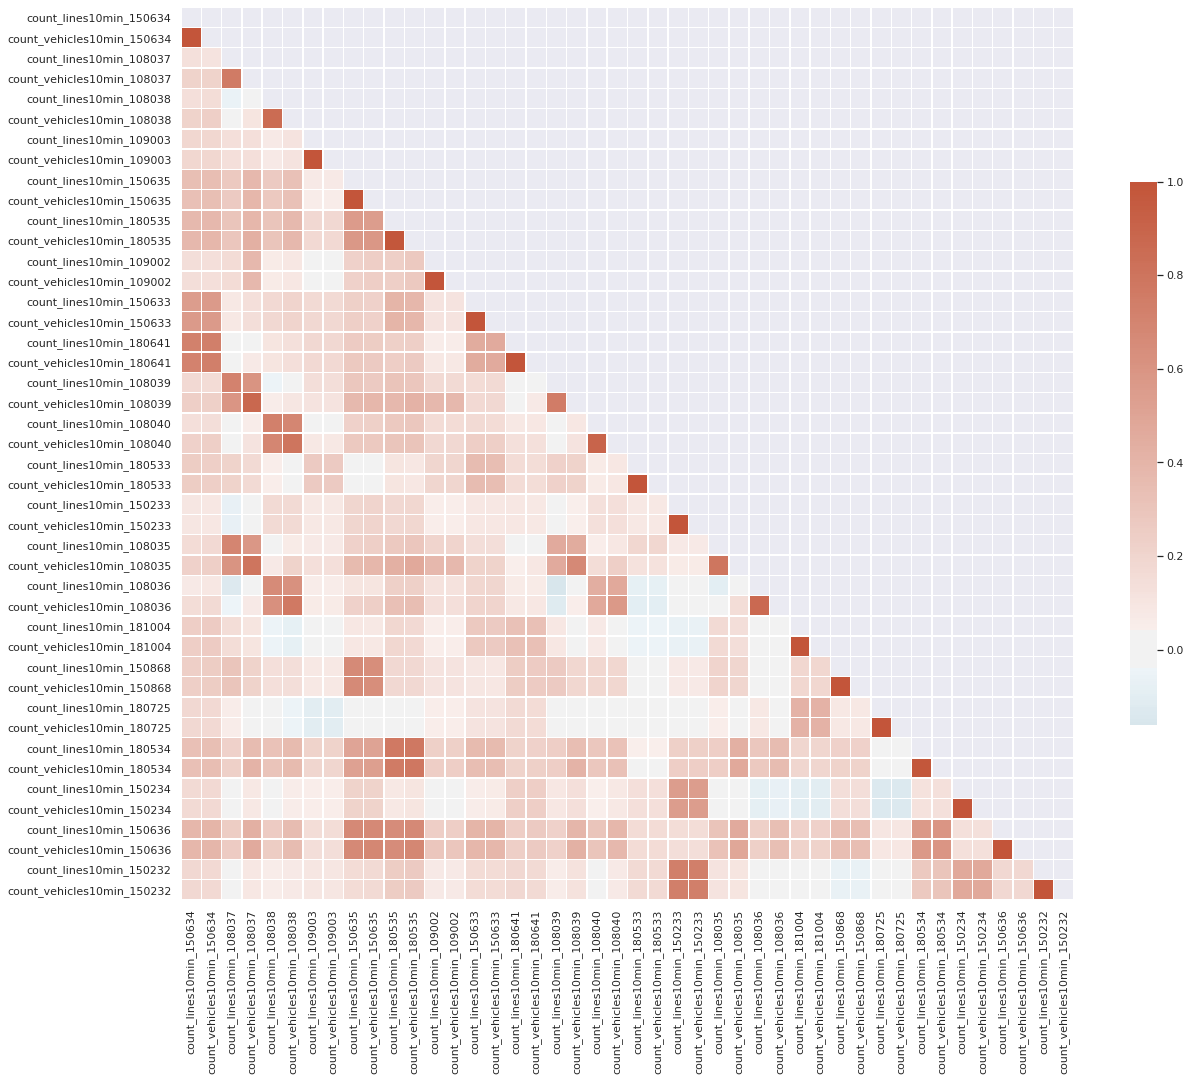

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#sns.set_theme(style="white")

# Compute the correlation matrix
corr = pdf.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
import seaborn as sns
sns.set(rc={'figure.figsize':(35.7,8.27)})

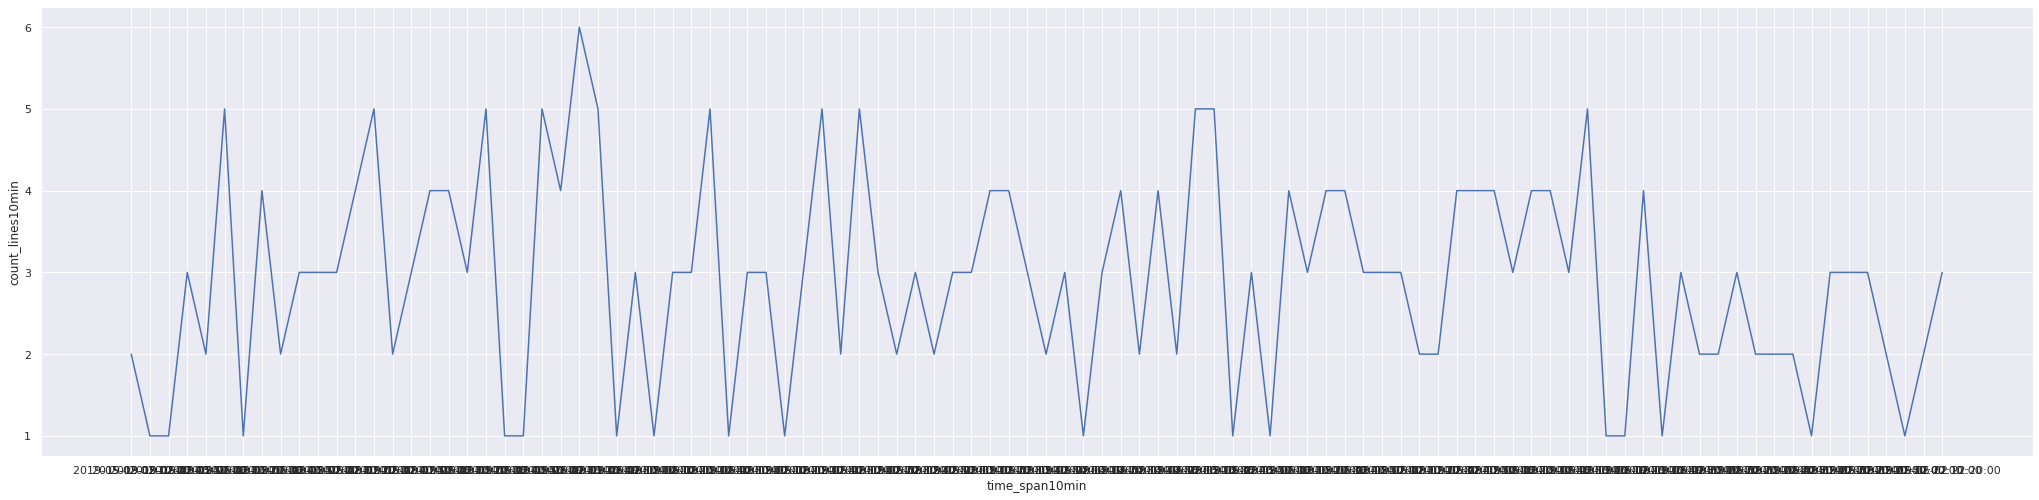

In [41]:
sns.lineplot(data=df_150634[(df_150634.day=="2")].head(100), x="time_span10min", y="count_lines10min")

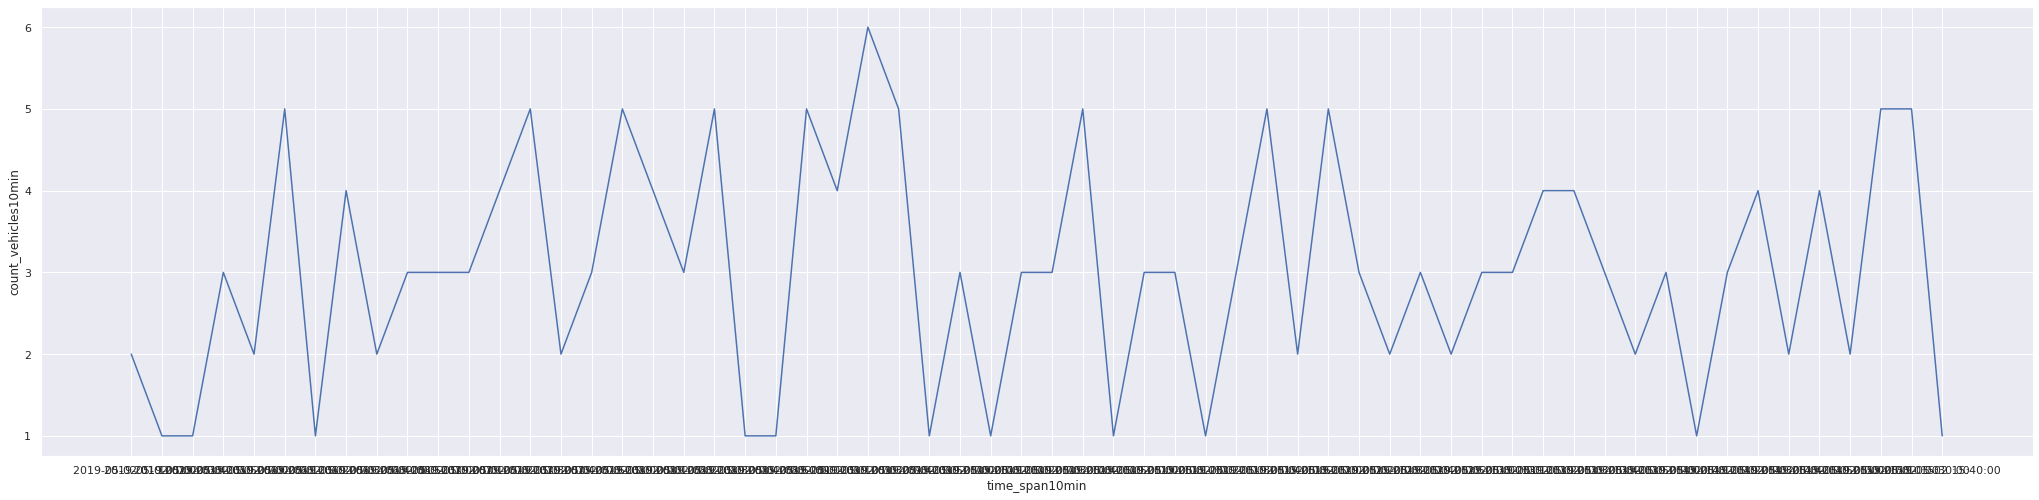

In [42]:
sns.lineplot(data=df_150634[(df_150634.day=="2")].head(60), x="time_span10min", y="count_vehicles10min")

> Alterar o grafo para contemplar o tempo médio de deslocamento entre dois pontos de todas as linhas

```sql
    (bs)-[:NEXT_BS {year,month,day,hour, time_avg, time_std, n_veic}]->(bs)  # um dia pode ter 24 arestas, realizar buscas através do tempo
```

- Identificar pontos com alta centralidade (demanda)
- Fixar um raio baseado no tempo médio de caminhada
- Identificar o número de pontos a área contempla e o número de linhas ( maximizar o número de linhas)
- Eleger top X áreas e criar arestas virtuais entre estes pontos com tempo médio de caminhada
- Realizar testes de deslocamento no grafo
- Identificar mudança topológica no grafo

https://pbpython.com/styling-pandas.html</br>
https://pbpython.com/monte-carlo.html</br>
https://github.com/chris1610/pbpython/blob/master/notebooks/Monte_Carlo_Simulation.ipynb</br>
http://www.flawofaverages.com/</br>

- I - calcular número de veículos que passaram nos pontos de ônibus
- II - calcular linhas atendidas nos pontos de ônibus
- III - criar raio de até 600m em torno do ponto de maior demanda ( testar demanda do dia / ou em uma janela de tempo sumarizada com média e desvio padrão )
- IV - Elencar 10 pontos de maior demanda de linhas e veículos ( é possível que estes pontos tenham maior centralidade de grau na rede estática )
- V - Identificar as demandas adjacentes aos 10 pontos no raio de 600m
- VI - Eleger 2 pontos de maior demanda  e demandas adjacentes
- VII - Criar novas arestas entre estes pontos no modelo de grafos do neo4j
- VIII - Analisar nova topologia da rede estática ( centralidade de grau, centralidade de intermediação, pagerank, diâmetro da rede)